In [6]:
# Cell 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import torch
import evaluate
import demoji
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import random # Add this import for the new augmentation

print("Imports complete. Setup ready.")

Imports complete. Setup ready.


In [3]:
# Cell 2: Load Your PREVIOUS Best Model and Data for Analysis
# --- THIS CELL IS FOR ERROR ANALYSIS ONLY ---

# IMPORTANT: Path to your previous best model's folder
# NEW, CORRECT LINE
PREVIOUS_BEST_MODEL_PATH = './results/specialist_two_stage_tune/checkpoint-404'

# We only need the sacred test set for this analysis
FRIENDS_DATA_PATH = '../data/data1.xlsx'

print("Loading previous best model and test data...")
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(PREVIOUS_BEST_MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(PREVIOUS_BEST_MODEL_PATH)
trainer = Trainer(model=model) # We use a simple Trainer for its .predict() method

# Load and preprocess the test data exactly as before
df_friends = pd.read_excel(FRIENDS_DATA_PATH)
df_friends.columns = [col.strip().lower() for col in df_friends.columns]
if 'entry' in df_friends.columns:
    df_friends.rename(columns={'entry': 'text'}, inplace=True)
df_friends.dropna(subset=['text', 'emotion'], inplace=True)
df_friends.drop_duplicates(subset=['text'], inplace=True)
test_df = df_friends.sample(frac=0.2, random_state=42) # Recreate the exact same test set
test_ds = Dataset.from_pandas(test_df)

demoji.download_codes()
def preprocess_text(batch):
    batch['text'] = [demoji.replace_with_desc(str(text), sep=" ") for text in batch['text']]
    return batch
test_ds = test_ds.map(preprocess_text, batched=True)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
tokenized_test_ds = test_ds.map(tokenize_fn, batched=True)

print("Model and data loaded. Ready to analyze errors.")

Loading previous best model and test data...


C:\Users\das99\AppData\Local\Temp\ipykernel_23252\3670051382.py:27: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()
Map: 100%|██████████| 200/200 [00:00<00:00, 6250.03 examples/s]

Model and data loaded. Ready to analyze errors.


--- Generating Error Reports ---


100%|██████████| 25/25 [00:00<00:00, 31.01it/s]



--- Classification Report ---
              precision    recall  f1-score   support

     Neutral       0.70      0.67      0.68        24
     Disgust       0.73      0.58      0.65        19
         Joy       0.67      0.67      0.67        27
        Fear       0.77      0.87      0.82        47
       Anger       0.62      0.51      0.56        39
     Sadness       0.66      0.75      0.70        44

    accuracy                           0.69       200
   macro avg       0.69      0.67      0.68       200
weighted avg       0.69      0.69      0.69       200


--- Confusion Matrix ---


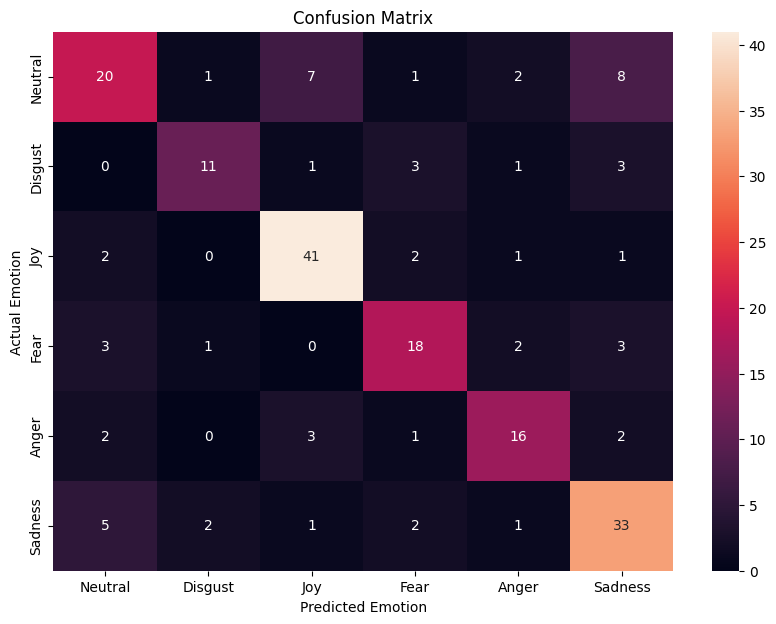


--- Examples of Misclassifications ---
                                                 text actual_emotion  \
0   All my life I've seen my friends lead a chill ...        Disgust   
3   Did a pull up challenge with hostel mates, man...        Neutral   
7   My dinner plan totally went bad. Now I'm just ...          Anger   
8   Ugh, the surprise scholarship shortlist was su...            Joy   
9   Haven't been able to spend much time with the ...          Anger   
12  So pumped after the all-night hackathon crash,...        Disgust   
16  Even a simple loan is not getting sanctioned.m...           Fear   
20  First full-length mock for GATE EC. Score 41/1...        Neutral   
21  I like to have the same breathless feeling as ...            Joy   
25  i need like... a nap, a spa day, and someone t...          Anger   
26  Going through functional depression. Ensuring ...        Neutral   
28  Back at home, reconnected with my school sweet...        Neutral   
31  We never started as 

In [5]:
# Cell 3: Run Prediction and Generate Reports
print("--- Generating Error Reports ---")

# Get model predictions on the test set
predictions = trainer.predict(tokenized_test_ds)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = tokenized_test_ds['emotion'] # Use the original string labels for clarity

# 1. Classification Report (Precision, Recall, F1-Score per class)
print("\n--- Classification Report ---")
class_names = model.config.id2label.values()
print(classification_report(y_true, [model.config.id2label[p] for p in y_preds], target_names=class_names))

# 2. Confusion Matrix (Where is the model getting confused?)
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, [model.config.id2label[p] for p in y_preds], labels=list(class_names))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

# 3. Show some specific mistakes
# --- SAFER WAY TO GET MISCLASSIFICATIONS ---

# 1. Get the predicted labels as a list of strings
predicted_labels = [model.config.id2label[p] for p in y_preds]

# 2. Create a clean copy of the test DataFrame and reset its index
#    This is the key step to ensure alignment with the predictions.
results_df = test_df.copy().reset_index(drop=True)

# 3. Add the actual and predicted labels as new columns to this new DataFrame
results_df['actual_emotion'] = y_true
results_df['predicted_emotion'] = predicted_labels

# 4. Now, it's easy and safe to filter for rows where the prediction was wrong
misclassified_df = results_df[results_df['actual_emotion'] != results_df['predicted_emotion']]

# 5. Display the misclassified examples clearly
print("\n--- Examples of Misclassifications ---")
# We select the columns to make the output easy to read
print(misclassified_df[['text', 'actual_emotion', 'predicted_emotion']].head(20))